# **BATSMAN RUN USING SARIMA**

In [33]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

In [15]:
# Load the data
deliveries = pd.read_csv('/content/deliveries.csv')  # Contains 'batsman_runs'
matches = pd.read_csv('/content/matches.csv')  # Contains 'date'

# Verify columns
print("Deliveries columns:", deliveries.columns)
print("Matches columns:", matches.columns)

Deliveries columns: Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')
Matches columns: Index(['id', 'season', 'city', 'date', 'match_type', 'player_of_match',
       'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'result', 'result_margin', 'target_runs', 'target_overs', 'super_over',
       'method', 'umpire1', 'umpire2'],
      dtype='object')


In [16]:
merged_df = deliveries.merge(matches[['id', 'date']], left_on='match_id', right_on='id')

In [17]:
# Verify the date range in total_df
print("Dataset date range:")
print("Start Date:", total_df.index.min())
print("End Date:", total_df.index.max())

Dataset date range:
Start Date: 2008-04-18 00:00:00
End Date: 2024-05-26 00:00:00


In [18]:
# Group by date and sum batsman_runs
total_df = merged_df.groupby('date')['batsman_runs'].sum().reset_index()

# Convert 'date' column to datetime and set as index
total_df["date"] = pd.to_datetime(total_df["date"])
total_df = total_df.set_index("date")
total_df = total_df.asfreq("D")
total_df = total_df.fillna(0)
print(total_df.index)

DatetimeIndex(['2008-04-18', '2008-04-19', '2008-04-20', '2008-04-21',
               '2008-04-22', '2008-04-23', '2008-04-24', '2008-04-25',
               '2008-04-26', '2008-04-27',
               ...
               '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20',
               '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24',
               '2024-05-25', '2024-05-26'],
              dtype='datetime64[ns]', name='date', length=5883, freq='D')


In [19]:
# Train-test split
train = total_df[:'2022']
test = total_df['2008-04-27':]
test.index

DatetimeIndex(['2008-04-27', '2008-04-28', '2008-04-29', '2008-04-30',
               '2008-05-01', '2008-05-02', '2008-05-03', '2008-05-04',
               '2008-05-05', '2008-05-06',
               ...
               '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20',
               '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24',
               '2024-05-25', '2024-05-26'],
              dtype='datetime64[ns]', name='date', length=5874, freq='D')

In [20]:
# SARIMAX Model parameters
p, d, q = 0, 1, 0
P, D, Q, s = 0, 0, 0, 0

# Fit SARIMAX Model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model = model.fit()

In [21]:
# Predictions
predicted_value = model.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
predicted_mean = predicted_value.predicted_mean

In [22]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predicted_mean))
print("RMSE:", rmse)


RMSE: 106.23577955669354


In [23]:
# Calculate MSE
mse = np.sqrt(mean_squared_error(test, predicted_mean))
print("MSE:", mse)

MSE: 106.23577955669354


In [24]:
mae = np.abs(test - predicted_mean)
print("MAE:", mae)

MAE:             batsman_runs  2008-04-27 00:00:00  2008-04-28 00:00:00  \
date                                                                 
2008-04-27           NaN                  NaN                  NaN   
2008-04-28           NaN                  NaN                  NaN   
2008-04-29           NaN                  NaN                  NaN   
2008-04-30           NaN                  NaN                  NaN   
2008-05-01           NaN                  NaN                  NaN   
...                  ...                  ...                  ...   
2024-05-22           NaN                  NaN                  NaN   
2024-05-23           NaN                  NaN                  NaN   
2024-05-24           NaN                  NaN                  NaN   
2024-05-25           NaN                  NaN                  NaN   
2024-05-26           NaN                  NaN                  NaN   

            2008-04-29 00:00:00  2008-04-30 00:00:00  2008-05-01 00:00:00  \
date   

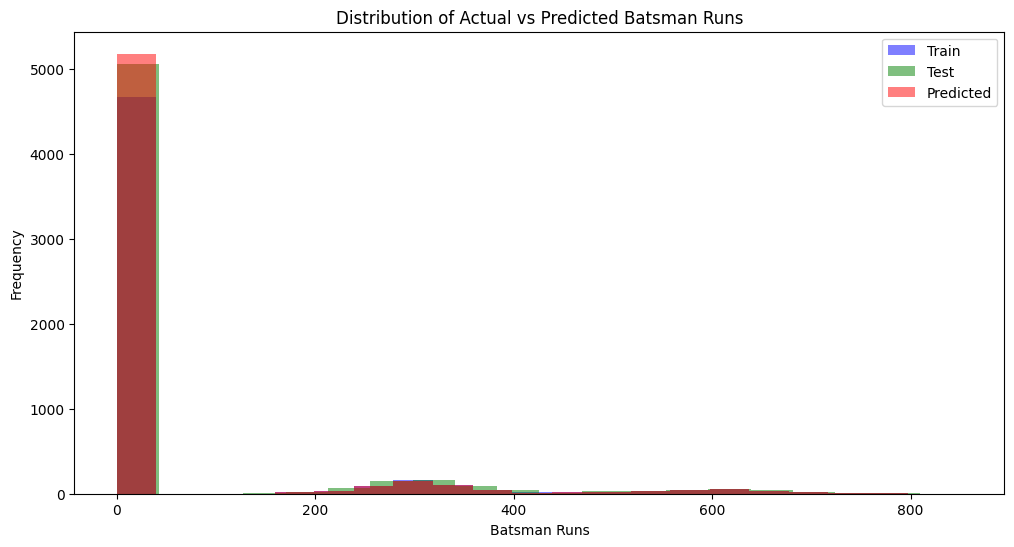

In [25]:
# Plot Histogram
plt.figure(figsize=(12, 6))

# Plot histogram for actual vs predicted
plt.hist(train['batsman_runs'], bins=20, alpha=0.5, label='Train', color='blue')
plt.hist(test['batsman_runs'], bins=20, alpha=0.5, label='Test', color='green')
plt.hist(predicted_mean, bins=20, alpha=0.5, label='Predicted', color='red')

# Add title and labels
plt.title('Distribution of Actual vs Predicted Batsman Runs')
plt.xlabel('Batsman Runs')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

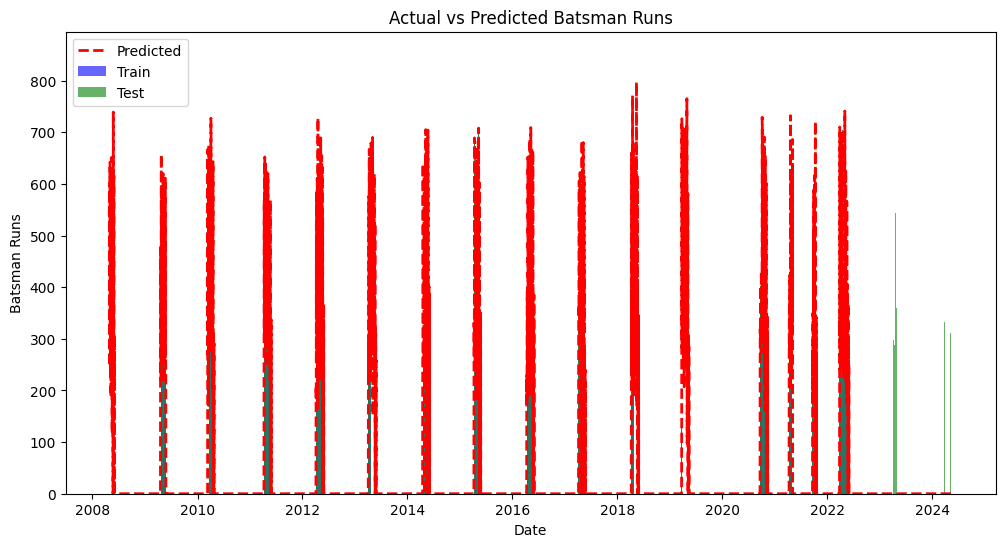

In [26]:
# Plot Bar Chart for Actual and Line Chart for Predicted
plt.figure(figsize=(12, 6))

# Bar chart for actual batsman runs (train and test)
plt.bar(train.index, train['batsman_runs'], label='Train', color='blue', alpha=0.6)
plt.bar(test.index, test['batsman_runs'], label='Test', color='green', alpha=0.6)

# Line chart for predicted batsman runs
plt.plot(test.index, predicted_mean, label='Predicted', color='red', linestyle='--', linewidth=2)

# Add title and labels
plt.title('Actual vs Predicted Batsman Runs')
plt.xlabel('Date')
plt.ylabel('Batsman Runs')

# Add legend
plt.legend()

# Show plot
plt.show()

## **WICKETS BY BOLWERS**

In [27]:
# Group by date and sum batsman_runs
total_df = merged_df.groupby('date')['is_wicket'].sum().reset_index()

# Convert 'date' column to datetime and set as index
total_df["date"] = pd.to_datetime(total_df["date"])
total_df = total_df.set_index("date")
total_df = total_df.asfreq("D")
total_df = total_df.fillna(0)
print(total_df.index)

DatetimeIndex(['2008-04-18', '2008-04-19', '2008-04-20', '2008-04-21',
               '2008-04-22', '2008-04-23', '2008-04-24', '2008-04-25',
               '2008-04-26', '2008-04-27',
               ...
               '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20',
               '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24',
               '2024-05-25', '2024-05-26'],
              dtype='datetime64[ns]', name='date', length=5883, freq='D')


In [28]:
# Train-test split
train = total_df[:'2022']
test = total_df['2008-04-27':]
test.index

DatetimeIndex(['2008-04-27', '2008-04-28', '2008-04-29', '2008-04-30',
               '2008-05-01', '2008-05-02', '2008-05-03', '2008-05-04',
               '2008-05-05', '2008-05-06',
               ...
               '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20',
               '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24',
               '2024-05-25', '2024-05-26'],
              dtype='datetime64[ns]', name='date', length=5874, freq='D')

In [29]:
# SARIMAX Model parameters
p, d, q = 0, 1, 0
P, D, Q, s = 0, 0, 0, 0

# Fit SARIMAX Model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model = model.fit()

In [30]:
# Predictions
predicted_value = model.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
predicted_mean = predicted_value.predicted_mean

In [31]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predicted_mean))
print("RMSE:", rmse)

RMSE: 4.270955666882769


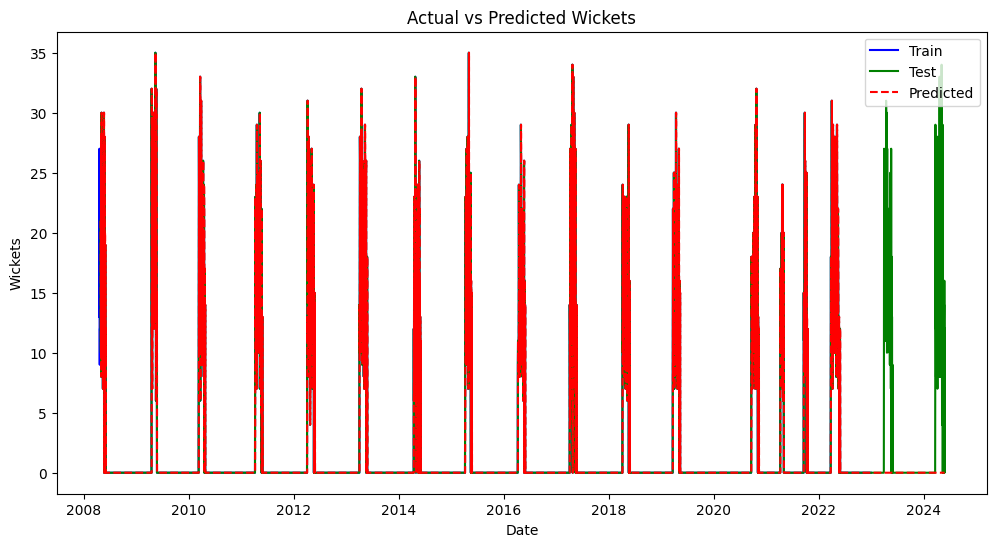

In [32]:
1# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['is_wicket'], label='Train', color='blue')
plt.plot(test.index, test['is_wicket'], label='Test', color='green')
plt.plot(test.index, predicted_mean, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Wickets')
plt.xlabel('Date')
plt.ylabel('Wickets')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

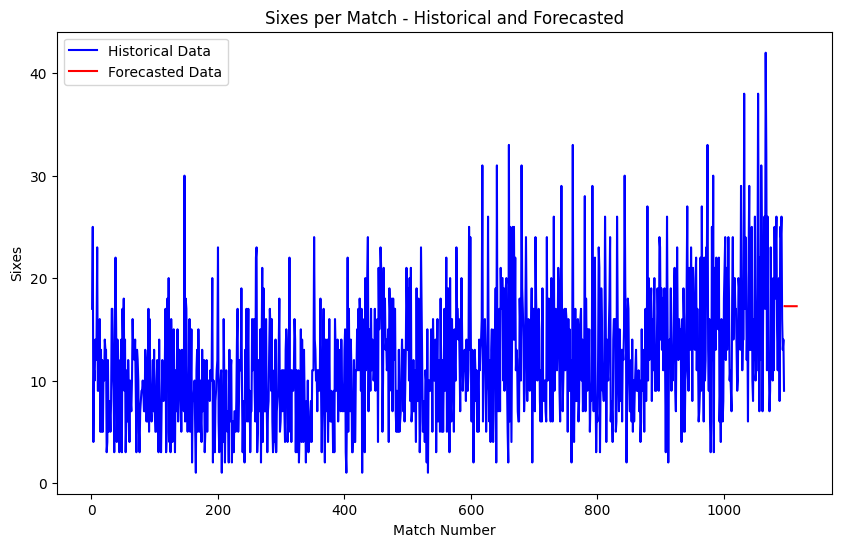

1095    17.261602
1096    17.254800
1097    17.254806
1098    17.254806
1099    17.254806
1100    17.254806
1101    17.254806
1102    17.254806
1103    17.254806
1104    17.254806
1105    17.254806
1106    17.254806
1107    17.254806
1108    17.254806
1109    17.254806
1110    17.254806
1111    17.254806
1112    17.254806
1113    17.254806
1114    17.254806
Name: predicted_mean, dtype: float64


In [36]:
deliveries['sixes'] = deliveries['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)

match_sixes = deliveries.groupby('match_id')['sixes'].sum().reset_index()

match_sixes['match_number'] = range(1, len(match_sixes) + 1)
match_sixes.set_index('match_number', inplace=True)

model = ARIMA(match_sixes['sixes'], order=(1, 1, 1))
model_fit = model.fit()

forecast_steps = 20
forecast_arima = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(10, 6))
plt.plot(match_sixes['sixes'], label='Historical Data', color='blue')
plt.plot(range(len(match_sixes) + 1, len(match_sixes) + 1 + forecast_steps),
         forecast_arima, label='Forecasted Data', color='red')
plt.title('Sixes per Match - Historical and Forecasted')
plt.xlabel('Match Number')
plt.ylabel('Sixes')
plt.legend()
plt.show()

print(forecast_arima)

# **Evaluation metric for SARIMA VS ARIMA**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

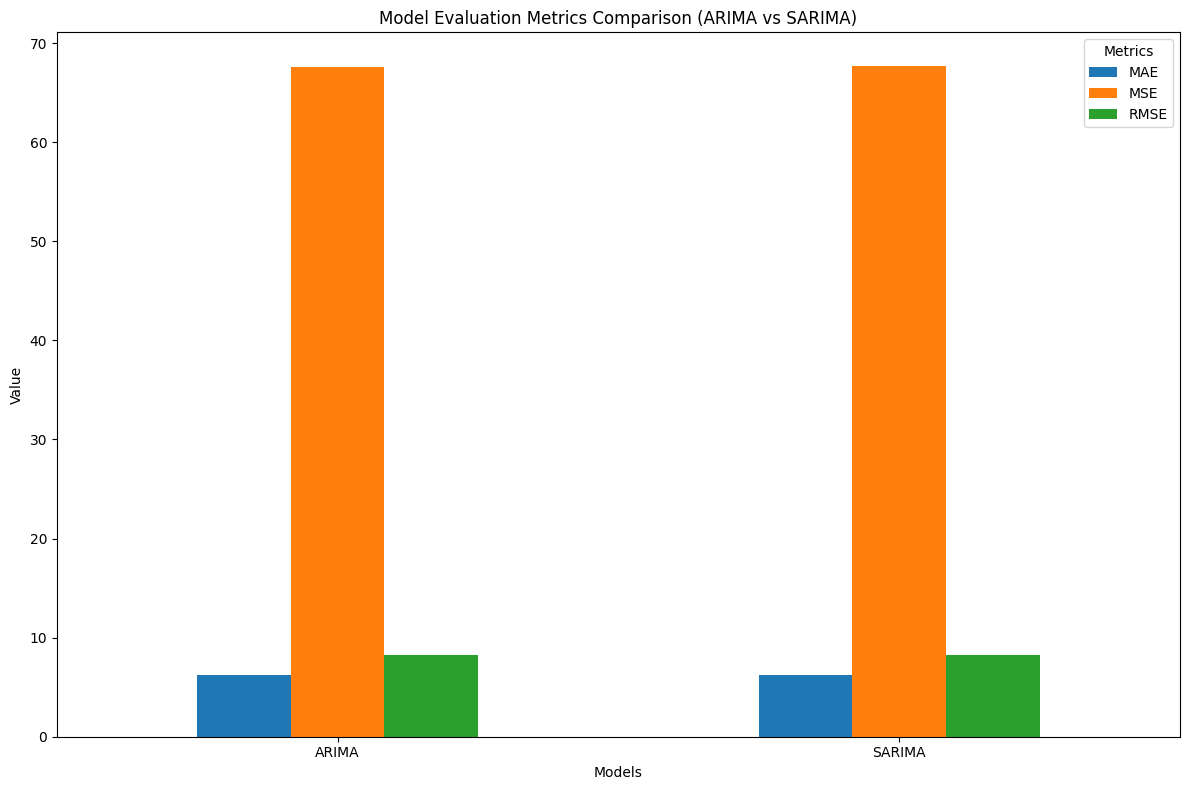

In [38]:
# Split data into training and testing sets
train_size = int(len(match_sixes) * 0.8)
train, test = match_sixes['sixes'][:train_size], match_sixes['sixes'][train_size:]

# ARIMA Model
arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

# SARIMA Model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
sarima_model_fit = sarima_model.fit(disp=False)

# ARIMA Predictions
arima_predictions = arima_model_fit.forecast(steps=len(test))

# SARIMA Predictions
sarima_predictions = sarima_model_fit.forecast(steps=len(test))

# Calculate Evaluation Metrics for ARIMA
arima_mae = mean_absolute_error(test, arima_predictions)
arima_mse = mean_squared_error(test, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Calculate Evaluation Metrics for SARIMA
sarima_mae = mean_absolute_error(test, sarima_predictions)
sarima_mse = mean_squared_error(test, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
# Create a DataFrame for easier plotting
metrics = pd.DataFrame({
    'MAE': [arima_mae, sarima_mae],
    'MSE': [arima_mse, sarima_mse],
    'RMSE': [arima_rmse, sarima_rmse],
}, index=['ARIMA', 'SARIMA'])

# Plot the evaluation metrics
metrics.plot(kind='bar', figsize=(12, 8))
plt.title('Model Evaluation Metrics Comparison (ARIMA vs SARIMA)')
plt.ylabel('Value')
plt.xlabel('Models')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()